# Credit Status Modelling

Objective: Predicting/classifying if potential loan applicants will be able to meet their payment obligation (target) based from their details (features) using different ML algorithms.

The training dataset includes details of past applicants as specified below:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off or in collection                                           |
| Principal      | Basic principal loan amount                                                           |
| Terms          | Weekly (7 days), biweekly, and monthly payoff schedule                                |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

## 1. Loading the dataset

First install the libraries required.

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

Load the dataset as a dataframe

In [2]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [3]:
df.shape

(346, 10)

There are 346 applicants from the training dataset

## 2. Data Processing

#### a. Understanding the dataset

In [4]:
# Install seaborn (alt: matplotlib)
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



In [5]:
import seaborn as sns

Visualize in terms of 3 features first - the principal amount, age, and day-of-week (separated by the gender of the applicants)

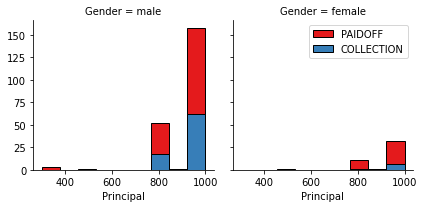

In [6]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)

# Plotting the data
g.map(plt.hist, 'Principal', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

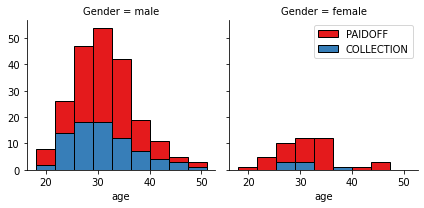

In [7]:
bins=np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)

# Plotting the data
g.map(plt.hist, 'age', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [8]:
# change the data type in the column to datetime format(from str)
df['effective_date'] = pd.to_datetime(df['effective_date'])

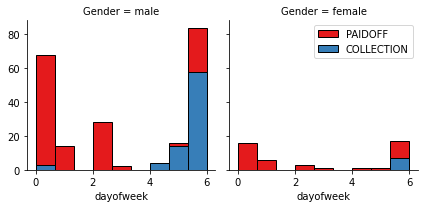

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins=np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)

# Plotting the data
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

Initial Observation: 
- The higher the principal amount, the higher the likelihood of defaulting.
- Males are more likely to default as the proportion of loans not being paid-off are higher for male applicants.
- Loans applied at the end of the week are more likely not to be paid-off

### b. String Indexing 

Observe the gender breakdown deeper.

In [10]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

Indeed Male are less likely to pay the loans than Female.

From the last observation, adds a feature (column) for end of the week applications (weekend)

In [11]:
df['weekend']= df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,10/7/2016,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,10/7/2016,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,9/22/2016,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,10/8/2016,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,10/8/2016,29,college,male,4,1


Converts the Male/Female in Gender column to 0/1

In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,10/7/2016,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,10/7/2016,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,9/22/2016,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,10/8/2016,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,10/8/2016,29,college,0,4,1


### c. One-Hot Encoding

Lets look at education.

In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

Use OHE to convert the categorical variables to binary variables in new columns.

In [14]:
feature = df[['Principal','terms','age','Gender','weekend']]
feature = pd.concat([feature,pd.get_dummies(df['education'])], axis=1)
# drop above master as the data seemed to contains outliers
feature.drop(['Master or Above'], axis = 1,inplace=True)
feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### d. Data Normalization

Also define the features (X) and target sets (y)

In [15]:
X = preprocessing.StandardScaler().fit(feature).transform(feature)
y = df['loan_status'].values

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [16]:
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

In [17]:
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## 3. Predictive Modelling

Use Classifications algorithms to construct the model.

But first lets do a data split (prevents over-fitting).

In [18]:
from sklearn.model_selection import train_test_split

# split the dataset into training and test set (8:2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

print ('Train set:', X_train.shape,  y_train.shape) 
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


### a. K Nearest Neighbours (KNN)

In [19]:
from sklearn.neighbors import KNeighborsClassifier

Find K value that minimizes the error (most accurate).

In [20]:
# test for values of K up to 15
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    # train and predict  
    kNN_model = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    yhat = kNN_model.predict(X_test)
    mean_acc[n-1] = np.mean(yhat==y_test);
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

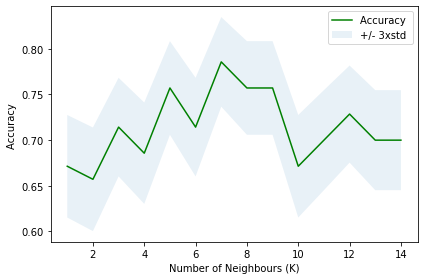

In [21]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

In [22]:
max(mean_acc)

0.7857142857142857

As can be seen above, the most accurate model is the one with K=7

In [23]:
# building the model again, using k=7
k = 7
kNN_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
yhat = kNN_model.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

### 2. Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier

Lets determine the best depth of the DT

In [25]:
from sklearn import metrics

d = 15
acc = np.zeros((d-1))

for n in range(3, d):
    DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    DT_model.fit(X_train,y_train)
    yhat = DT_model.predict(X_test)
    acc[n-3] = metrics.accuracy_score(y_test, yhat)
    
acc

array([0.61428571, 0.61428571, 0.64285714, 0.77142857, 0.75714286,
       0.75714286, 0.65714286, 0.7       , 0.7       , 0.71428571,
       0.71428571, 0.72857143, 0.        , 0.        ])

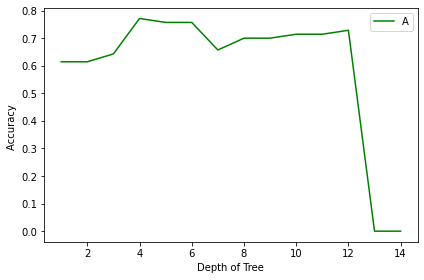

In [26]:
plt.plot(range(1,d),acc,'g')
plt.legend(('Accuracy '))
plt.ylabel('Accuracy ')
plt.xlabel('Depth of Tree')
plt.tight_layout()
plt.show()

In [27]:
max(acc)

0.7714285714285715

As can be seen above, the most accurate model is with the depth of tree = 6

In [28]:
# building the model again, using d= 6
DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
DT_model.fit(X_train,y_train)
yhat = DT_model.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

### c. Support Vector Machine (SVM)

In [29]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import itertools

Lets check accuracy of different kernel functions using Confusion Matrix.

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [31]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
    SVM_model = svm.SVC(kernel=kernel)
    SVM_model.fit(X_train, y_train) 
    yhat = SVM_model.predict(X_test)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, yhat)
    np.set_printoptions(precision=2)
    print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

              precision    recall  f1-score   support

  COLLECTION       0.33      0.07      0.11        15
     PAIDOFF       0.79      0.96      0.87        55

   micro avg       0.77      0.77      0.77        70
   macro avg       0.56      0.52      0.49        70
weighted avg       0.69      0.77      0.71        70

              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

   micro avg       0.74      0.74      0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

              preci

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/svm/b

As can be seen from the result, Radial Basis Function is the most accurate kernel for the model.

In [32]:
SVM_model = svm.SVC(kernel='rbf')
SVM_model.fit(X_train, y_train) 
yhat = SVM_model.predict(X_test)
yhat[0:5]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

### d. Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
LR_model = LogisticRegression(C=0.01).fit(X_train,y_train)
yhat = LR_model.predict(X_test)
yhat[0:5]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## 3. Compare Performance of the Models

Load the test dataset to measure real-life accuracy

In [35]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


Repeat the data processing process 

In [36]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
test_X = preprocessing.StandardScaler().fit(test_Feature).transform(test_Feature)
test_X[0:5]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.49,  0.93,  3.06,  1.98, -1.3 ,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51,  0.77, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98,  0.77, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.77,  2.4 , -0.8 , -0.86]])

In [37]:
test_y = test_df['loan_status'].values
test_y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

Lets compare the models using F1 score, Jaccard Index, and Log Loss (Logistic Regression only)

In [38]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [39]:
knn_yhat = kNN_model.predict(test_X)
print("KNN Jaccard index: %.2f" % jaccard_similarity_score(test_y, knn_yhat))
print("KNN F1-score: %.2f" % f1_score(test_y, knn_yhat, average='weighted') )

KNN Jaccard index: 0.67
KNN F1-score: 0.63


In [40]:
DT_yhat = DT_model.predict(test_X)
print("DT Jaccard index: %.2f" % jaccard_similarity_score(test_y, DT_yhat))
print("DT F1-score: %.2f" % f1_score(test_y, DT_yhat, average='weighted') )

DT Jaccard index: 0.72
DT F1-score: 0.67


In [41]:
SVM_yhat = SVM_model.predict(test_X)
print("SVM Jaccard index: %.2f" % jaccard_similarity_score(test_y, SVM_yhat))
print("SVM F1-score: %.2f" % f1_score(test_y, SVM_yhat, average='weighted') )

SVM Jaccard index: 0.80
SVM F1-score: 0.76


In [42]:
LR_yhat = LR_model.predict(test_X)
LR_yhat_prob = LR_model.predict_proba(test_X)
print("LR Jaccard index: %.2f" % jaccard_similarity_score(test_y, LR_yhat))
print("LR F1-score: %.2f" % f1_score(test_y, LR_yhat, average='weighted') )
print("LR LogLoss: %.2f" % log_loss(test_y, LR_yhat_prob))

LR Jaccard index: 0.74
LR F1-score: 0.66
LR LogLoss: 0.57


### Summary

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.67    | 0.63     | NA      |
| Decision Tree      | 0.72    | 0.67     | NA      |
| SVM                | 0.80    | 0.76     | NA      |
| LogisticRegression | 0.74    | 0.66     | 0.57    |

### Conclusion 

SVM with Radial Basis Function kernel is the most accurate out of the four models.